In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

In [13]:
data_path_list = [r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r1/oc3-coar/adavosertib.csv',
                  r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r2-reim/oc3-coar/ada.csv']

concentrations = [.00001,.0005,.001,.01,.1,.5,1,5]

In [14]:
base_df = pd.DataFrame(columns=['n#','cell line','drug','condition','label','area','DAPI-mean','EdU-mean','Int-DNA'])

for data_path in data_path_list:
    temp_df = pd.read_csv(data_path)
    temp_df['Int-DNA'] = temp_df['DAPI-mean']*temp_df['area']

    base_df = pd.concat([base_df,temp_df])

/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_32683/862202972.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df,temp_df])


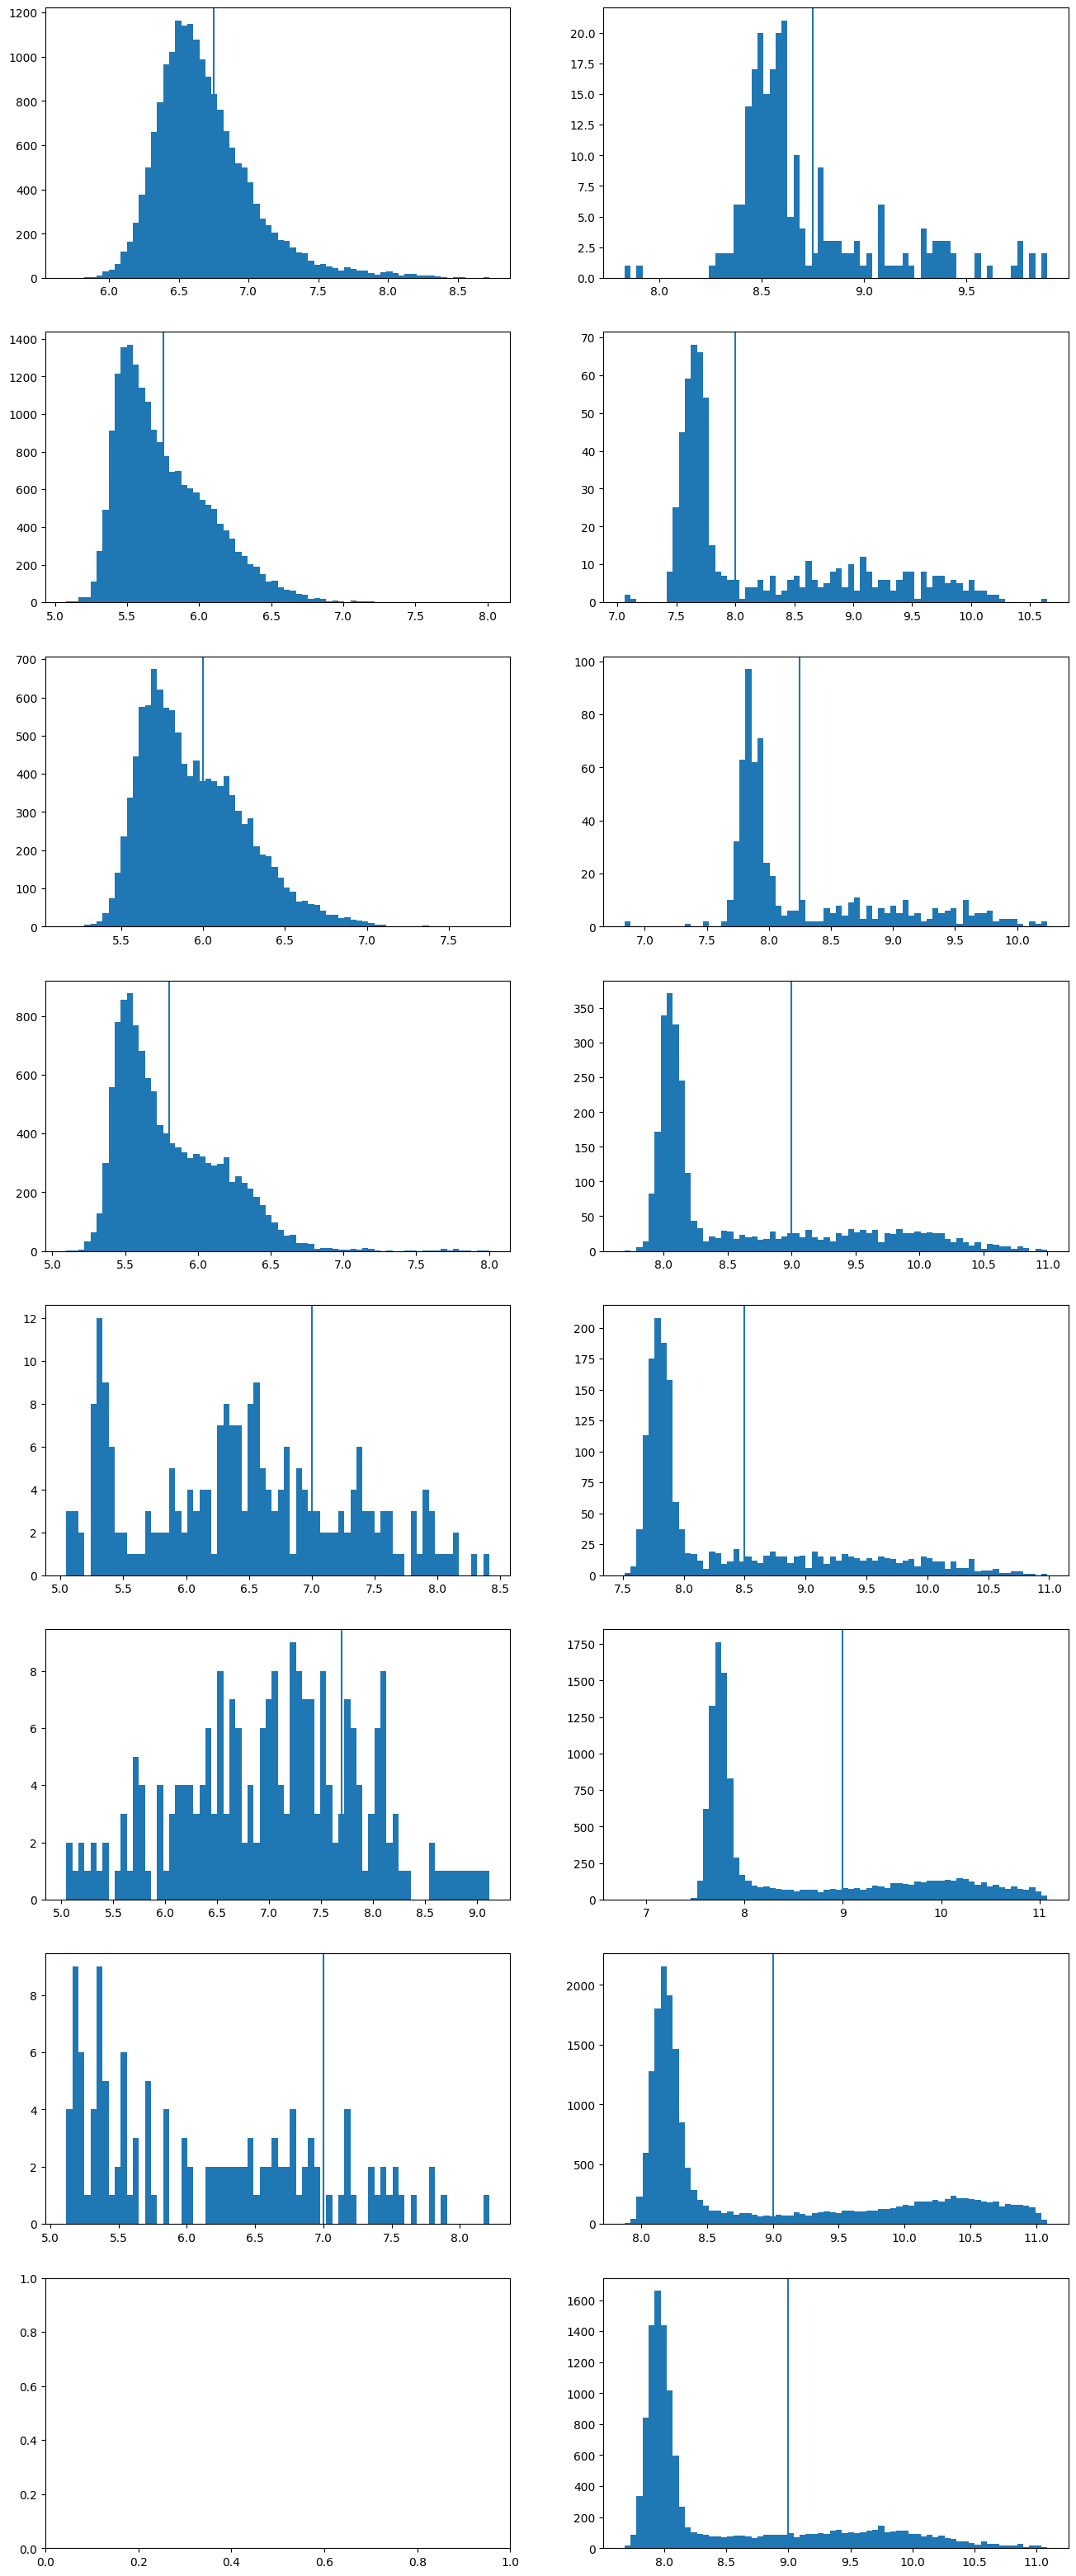

In [19]:
# EdU Positivity Graphs
fig,axs = plt.subplots(8,len(data_path_list),
                       figsize=(8*len(data_path_list),40))

threshold_list = [[6.75,5.75,6,5.8,7,7.7,7,6],
                  [8.75,8,8.25,9,8.5,9,9,9]]

pos_prop_list = []
 

for ind,rep in enumerate(np.unique(base_df['n#'])):
    cell_line_df = base_df[base_df['n#']==rep]
    prop_list = []

    for jind,condition in enumerate(np.unique(base_df['condition'])):
        cdf = cell_line_df[cell_line_df['condition']==condition]
        axi = axs[jind,ind]

        edu_data = cdf['EdU-mean']
        edu_log = np.log([x for x in edu_data if x!=0])

        if len(edu_data)!=0: 
            thresh = threshold_list[ind][jind]

            axi.hist(edu_log,bins=70)
            axi.axvline(thresh)

            pos_df = cdf[cdf['EdU-mean'] > np.exp(thresh)]
            pos_prop = len(pos_df)/len(cdf)

            prop_list.append(pos_prop)
        else: prop_list.append(0)

    #prop_norm_list = [x/prop_list[0] for x in prop_list]
    #pos_prop_list.append(prop_norm_list)

    pos_prop_list.append(prop_list)

/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_32683/1889439488.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(sigmoid,


E-Max Values: [1.9396428907469954e-11, -0.052670935422927334]
E-Max: -0.026335467701765453
IC-50 Values: [0.15301122401224015, 4.577046616366164]
IC-50: 2.365028920189202


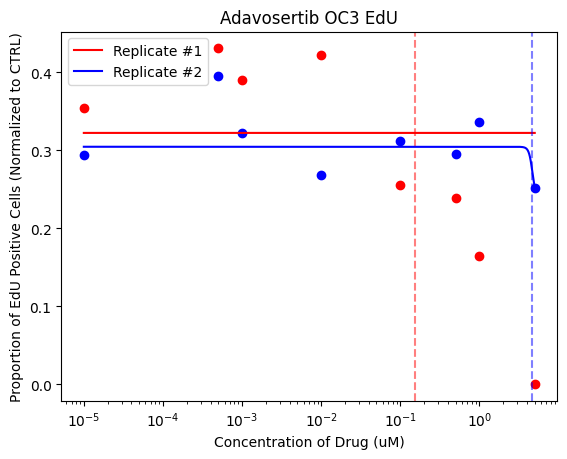

In [21]:
def sigmoid(x, a, b, c, d):
    return a / (1.0 + np.exp(-c * (x - d)))+b

to_ignore = [[7],[1]]
ic50_list = []
labels = ['Replicate #1', 'Replicate #2', 'Replicate #3']
colors = ['red','blue','green']
emax_list = []
plt.xscale('log')

for ind,pos_prop in enumerate(pos_prop_list):
    plt.scatter(x=concentrations,y=pos_prop,color=colors[ind])

    concentration_fin = [x for i,x in enumerate(concentrations) if i not in to_ignore[ind]]
    pos_prop_fin = [x for i,x in enumerate(pos_prop) if i not in to_ignore[ind]]

    popt,pcov = curve_fit(sigmoid,
                      concentration_fin,
                      pos_prop_fin,
                      maxfev=10000)

    x_fit = np.linspace(min(concentrations),max(concentrations),100000)
    y_fit = sigmoid(x_fit,*popt)

    half_effect = (y_fit[0]+y_fit[-1])/2
    ic50 = x_fit[(np.argmin(np.abs([x-half_effect for x in y_fit])))]
    ic50_list.append(ic50)

    plt.axvline(ic50,color=colors[ind],linestyle='--',alpha=.5)
    plt.plot(x_fit,y_fit,color=colors[ind],label=labels[ind])
    emax = y_fit[-1]-y_fit[0]
    emax_list.append(emax)
print(f'E-Max Values: {emax_list}')
print(f'E-Max: {np.average(emax_list)}')

plt.legend()
plt.title('Adavosertib OC3 EdU')
plt.ylabel('Proportion of EdU Positive Cells (Normalized to CTRL)')
plt.xlabel('Concentration of Drug (uM)')

print(f'IC-50 Values: {ic50_list}')
print(f'IC-50: {np.average(ic50_list)}')

/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_32683/1502451095.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = data.groupby('concentration').apply(calculate_percentage_positive).reset_index()
/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_32683/1502451095.py:53: RuntimeWarning: divide by zero encountered in log10
  x_fit = np.logspace(np.log10(min(grouped_data['concentration'])), np.log10(max(grouped_data['concentration'])), 100)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Library/Frameworks/Python.framework/Versions/3

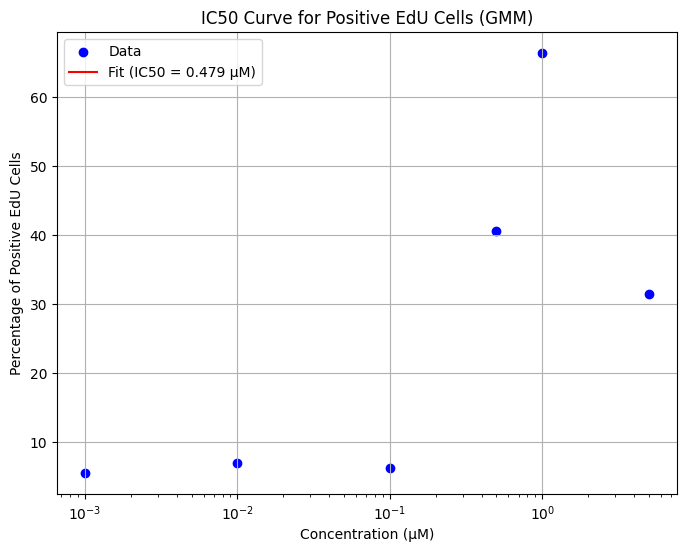

0.47937653201124514

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

# Load your CSV file
file_path = r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r2-reim/oc3-coar/ada.csv'
data = pd.read_csv(file_path)

# Map conditions to concentrations
concentration_map = {
    'A': 0,
    'B': 0.001,
    'C': 0.01,
    'D': 0.1,
    'E': 0.5,
    'F': 1,
    'G': 5,
    'H': 10
}
data['concentration'] = data['condition'].map(concentration_map)

# Fit a Gaussian Mixture Model (GMM) on the EdU-mean values
gmm = GaussianMixture(n_components=2)  # Assuming 2 clusters (low and high EdU)
edu_mean = data[['EdU-mean']].values
gmm.fit(edu_mean)

# Get the probability that each cell belongs to the positive (high EdU) cluster
# The cluster with the higher mean is assumed to be the 'positive' cluster
gmm_probs = gmm.predict_proba(edu_mean)
high_edu_cluster = np.argmax(gmm.means_)  # Index of the high EdU cluster
data['positive_probability'] = gmm_probs[:, high_edu_cluster]

# Group data by concentration and calculate the percentage of positive cells
def calculate_percentage_positive(group):
    return np.mean(group['positive_probability']) * 100

grouped_data = data.groupby('concentration').apply(calculate_percentage_positive).reset_index()
grouped_data.columns = ['concentration', 'percentage_positive']

# Define a sigmoid function for curve fitting
def sigmoid(x, top, bottom, IC50, hill_slope):
    return bottom + (top - bottom) / (1 + (x / IC50)**hill_slope)

# Initial guesses for curve fitting parameters
initial_guesses = [max(grouped_data['percentage_positive']), min(grouped_data['percentage_positive']), 1, 1]

# Perform curve fitting to find the IC50
popt, _ = curve_fit(sigmoid, grouped_data['concentration'], grouped_data['percentage_positive'], p0=initial_guesses)

# Generate data for plotting the fitted curve
x_fit = np.logspace(np.log10(min(grouped_data['concentration'])), np.log10(max(grouped_data['concentration'])), 100)
y_fit = sigmoid(x_fit, *popt)

# Plot the percentage of positive cells and the fitted IC50 curve
plt.figure(figsize=(8, 6))
plt.scatter(grouped_data['concentration'], grouped_data['percentage_positive'], label='Data', color='blue')
plt.plot(x_fit, y_fit, label=f'Fit (IC50 = {popt[2]:.3f} µM)', color='red')
plt.xscale('log')
plt.xlabel('Concentration (µM)')
plt.ylabel('Percentage of Positive EdU Cells')
plt.title('IC50 Curve for Positive EdU Cells (GMM)')
plt.legend()
plt.grid(True)
plt.show()

# Display IC50 value
popt[2]

In [18]:
import napari
napari.Viewer()

Viewer(camera=Camera(center=(0.0, 0.0, 0.0), zoom=1.0, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0, 2, 1), (0, 2, 1)), current_step=(0, 0), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[], help='', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x298d45300>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})